# Assignment 2

**Deadline**:  Sunday 12 December, 23.59.

Your notebook should not give errors when executed with `Run All`. Please submit your answers via [Canvas](https://canvas.uva.nl/courses/25150/assignments/248823).

|**Name**|**Student ID**|**Email**|
|:-------|:-------------|:--------|
|Yechan Kim        |11630655              |kkyc1227@naver.com         |


#### Hand in the following:
* Your notebook. **click on `Kernel`, then `Restart & Run All`** before submitting.
* A (printed) pdf version of your notebook.

#### NOTES:
* This is an individual assignment. Teamwork is **not** permitted, including during lectures.
* The assignment is a partial stand-in for a final examination, so the usual rules regarding plagiarism and fraud apply, with all attendant consequences. Code found on the internet or elsewhere is not acceptable as a solution.
* Efficient code is required for full marks.
* Make sure that any function you write has a docstring, and comments where appropriate.
* Before submitting your work, **click on `Kernel`, then `Restart & Run All`** and verify that your notebook produces the desired results and does not error.
* Some questions require you to write code to obtain a numerical result (e.g., an option price). In that case, don't just give the function, but also the result of calling it with the given parameter values (i.e., the numerial value that it returns). If your function uses random numbers, then set the seed to 0 before calling it. This makes it much easier to grade the assignments (at least as long as the answer is correct).
* How to convert your notebook to pdf: The easiest way is probably to use your browser's print functionality: e.g. in Chrome, press the three dots to go to Options, select 'Print...', and then select 'save as pdf' as Destination. I usually set it to 70% zoom such that the output fits the printed pdf pages.


#### Declaration of Originality:
By submitting these answers, I declare that
1. I have read and understood the notes above.
2. These solutions are solely my own work.
3. I have not made these solutions available to any other student.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

**Question A**:
Consider an $N$-period model with two assets: a riskless bond with value $B_t=e^{rt}$, and a stock that evolves according to a binomial tree, such that $S_t=S_{t-\Delta t}u$ or $S_t=S_{t-\Delta t}d$ in the good and bad states of the world, respectively. Here $u=1/d=\exp(\sigma\sqrt{\Delta t})$ and $\Delta t= T/N$ as usual. We would like to price a *chooser* option, which has the property that, after $M<N$ periods, the holder can choose whether the option is a European call or put option, both maturing after $N$ periods, and with the same strike price $K$ (See Hull, section 25.7 (ed. 8) or 26.8 (ed. 9, 10, or 11)). Denoting their prices after $i$ periods as $C_{i}$ and $P_{i}$, respectively, the value of the chooser option after $M$ periods is $V_{M}=\max \{C_{M},P_{M}\}\,$. Our starting point is the function `calltree` (or `calltree_numpy`) from Week 5. 

**For each of the following subquestions, your answer should include the function itself, as well as the result of calling it with the following parameter values**: $S_0 = 12$, $K = 15$, $T = 3/12$, $r = 0.02$, $\sigma = 0.25$, $q = 0.01$, $N = 500$, $M=200$.

   1. We want to allow for a dividend yield, $q$. Modify `calltree_numpy` to accept an additional input argument `q`. That is, the function becomes `calltree_numpy(S0, K, T, r, sigma, q, N)`. In the function change the risk-neutral probability to $(e^{(r-q)\Delta t}-d)/(u-d)$.
   2. Building on your function from the previous question write a function `chooser(S0, K, T, r, sigma, q, N, M)` that prices a European chooser option. Along with the call price tree, this function should also compute a put price tree stored in a matrix `P` (of the same size as the call price matrix). Following computation of `C` and `P`, create a $(M+1) \times (M+1)$ matrix `CH`, which stores the tree for the chooser option. At point in time `M`, the last column of this tree will be populated with $V_M=\max \{C_{M},P_{M}\}\,$. Based on the `CH` tree perform the backwards induction to determine the price of the chooser.
   3. Now consider a chooser option for which after $M$ periods, the holder will choose between an *American* call or an *American* put (above we were choosing between a *European* call and a *European* put). Modify the function from above so that before populating the chooser tree `CH` the first loop also determines whether to exercise or keep the respective *American* put and *American* call. Call the function that evaluates the price of this particular derivative `chooser_american(S0, K, T, r, sigma, q, N, M)`.
   4. For the given parameters values ($S_0$, $K$, $T$, $r$, $\sigma$, $q$, $N$) plot the prices of `chooser` and `chooser_american` as a function of $M$. That is, produce a graph that has the prices of the two options on the y-axis and $M$ on the x-axis. Describe and explain (in words) the price convergence.

Question A 1

In [2]:
# set the option parameters
S0 = 12.; K = 15.; T = 3/12.; r = .02; sigma = .25; q = 0.01; N = 500; M = 200;

def calltree_numpy(S0, K, T, r, sigma, q, N):
    """European call price based on an N-step binomial tree with the dividend yield"""
    deltaT = T / float(N)
    u = np.exp(sigma*np.sqrt(deltaT))
    d = 1.0 / u
    p = (np.exp((r-q)*deltaT)-d) / (u-d)
    piu = np.exp(-r*deltaT) * p
    pid = np.exp(-r*deltaT) * (1-p)
    C = np.zeros((N+1, N+1))
        
    # Stock Price
    S = S0 * u**np.arange(N+1) * d**(2*np.arange(N+1)[:, np.newaxis])
    S = np.triu(S) #keep only the upper triangular part

    # Final Payoffs
    C[:, N] = np.maximum(0, S[:, N]-K) #note: np.maximum in place of max

    # Work backwards through the tree
    for j in range(N-1, -1, -1):
        C[:j+1, j] = piu * C[:j+1, j+1] + pid * C[1:j+2, j+1]

    return C[0, 0]


calltree_numpy(S0, K, T, r, sigma, q, N)


0.025863747363824963

Question A 2

In [3]:
def chooser(S0, K, T, r, sigma, q, N, M):
    """European chooser option based on an N-step binomial tree"""
    
    # Option Parameters
    deltaT = T / float(N)
    u = np.exp(sigma*np.sqrt(deltaT))
    d = 1.0 / u
    p = (np.exp((r-q)*deltaT)-d) / (u-d)
    piu = np.exp(-r*deltaT) * p
    pid = np.exp(-r*deltaT) * (1-p)
    
    # For this question, I run the same process for both Call and Put Option
    C = np.zeros((N+1, N+1)) # Call Option
    P = np.zeros((N+1, N+1)) # Put Option
        
    # Stock Price
    S = S0 * u**np.arange(N+1) * d**(2*np.arange(N+1)[:, np.newaxis])
    S = np.triu(S) #keep only the upper triangular part
    
    # Final Payoffs for both Call and Put Option
    C[:, N] = np.maximum(0, S[:, N]-K) #note: np.maximum in place of max
    P[:, N] = np.maximum(0, K-S[:, N]) #note: np.maximum in place of max
        
    # Work backwards through the tree for both Call and Put Option
    for j in range(N-1, -1, -1):
        C[:j+1, j] = piu * C[:j+1, j+1] + pid * C[1:j+2, j+1]
        P[:j+1, j] = piu * P[:j+1, j+1] + pid * P[1:j+2, j+1]
    
    # Perform the same process for the Chooser Option
    
    # Definition of Chooer Option
    CH = np.zeros((M+1, M+1)) # Chooser Option
    
    # Final Payoffs for Chooser Option
    CH[:, M] = np.maximum(C[:M+1, M], P[:M+1, M])
    
    # Work backwards through the tree for Chooser Option
    for j in range(M-1, -1, -1):
        CH[:j+1, j] = piu * CH[:j+1, j+1] + pid * CH[1:j+2, j+1]
        
    return CH[0,0]

chooser(S0, K, T, r, sigma, q, N, M)

2.981816416843708

Question A 3

In [4]:
def chooser_american(S0, K, T, r, sigma, q, N, M):
    """American Chooser Option based on an N-step binomial tree"""
    
    # Option Parameters
    deltaT = T / float(N)
    u = np.exp(sigma*np.sqrt(deltaT))
    d = 1.0 / u
    p = (np.exp((r-q)*deltaT)-d) / (u-d)
    piu = np.exp(-r*deltaT) * p
    pid = np.exp(-r*deltaT) * (1-p)
    
    # For this question, I run the same process for both American Call and Put Option
    C = np.zeros((N+1, N+1)) # Call Option
    P = np.zeros((N+1, N+1)) # Put Option
        
    # Stock Price
    S = S0 * u**np.arange(N+1) * d**(2*np.arange(N+1)[:, np.newaxis])
    S = np.triu(S) #keep only the upper triangular part
    
    # Final Payoffs for both American Call and Put Option
    C[:, N] = np.maximum(0, S[:, N]-K) #note: np.maximum in place of max
    P[:, N] = np.maximum(0, K-S[:, N]) #note: np.maximum in place of max
        
    # Work backwards through the tree for both American Call and Put Option
    for j in range(N-1, -1, -1):
        C[:j+1, j] = piu * C[:j+1, j+1] + pid * C[1:j+2, j+1]
        C[:j+1, j] = np.maximum(C[:j+1, j], S[:j+1, j]-K ) # added for the American Call Price
        P[:j+1, j] = piu * P[:j+1, j+1] + pid * P[1:j+2, j+1]
        P[:j+1, j] = np.maximum(P[:j+1, j], K-S[:j+1, j] ) # added for the American Put Price
            
    # Perform the same process for the American Chooser Option
    
    # Definition of American Chooer Option
    CH = np.zeros((M+1, M+1)) # Chooser Option
    
    # Final Payoffs for Chooser Option
    CH[:, M] = np.maximum(C[:M+1, M], P[:M+1, M])
    
    # Work backwards through the tree for Chooser Option
    for j in range(M-1, -1, -1):
        CH[:j+1, j] = piu * CH[:j+1, j+1] + pid * CH[1:j+2, j+1]
        #CH[:j+1, j] = np.maximum(P[:j+1, j], K-S[:j+1, j] )
        
    return CH[0,0]

chooser_american(S0, K, T, r, sigma, q, N, M)

3.0019380410392396

Question A 4

In [5]:
def plot_chooser_options (S0, K, T, r, sigma, q, N ):
    """Plot the prices of "chooser (European)" and "chooser_american" as a function of M"""
    
    # A function of M
    
    # x-axis
    M = range(0, 500) # N = 500
    
    # y-axis
    CH_EU = [chooser(S0, K, T, r, sigma, q, N, i) for i in M ]
    CH_AM = [chooser_american(S0, K, T, r, sigma, q, N, j) for j in M ]
    
    # plot specifications
    plt.plot(M, CH_EU) # A Function shows the Prices of European Chooser Option
    plt.plot(M, CH_AM) # A Function shows the Prices of American Chooser Option
    plt.title("Prices of European and American Chooser Option")
    plt.xlabel("M")
    plt.ylabel("Prices of two Chooser Options")
    plt.show()

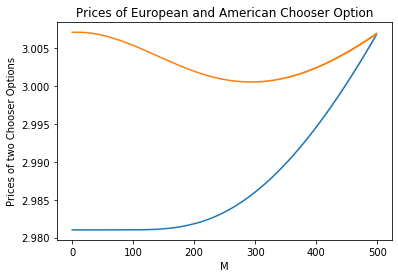

In [6]:
plot_chooser_options (S0, K, T, r, sigma, q, N )

The blue line indicates the prices of the (European) chooser option.
The orange line indicates the prices of the American chooser option. 
The prices of the European and American chooser option converges at the end of the period (N = 500). 

To be specific, as answered in the previous questions, the price of put option is larger than the price of call option for both the (European) chooser option and the American chooser option. Thus, the graph shows the difference between the European and American put option because the chooser options are designed to choose the higher price option. 

The American put option is more valuable than the European put option when the American option is exercised earky before the expiration date (N = 500). An early exercise of American put option is more valuable when the exercise is far away from the expiration date. 

As the American put option approaches to the expiration date (N = 500 in this case), the advantage of the early exercise disappears. In other words, the American put option will be equal to the European put option at the expiration date (N = 500). This is the reason of price convergence. 


 **Question B**:

 We wish to obtain the no-arbitrage price $X_{0}$ of an index-linked certificate. The derivative has payoff $X_{T}$, defined from the path of an equity index $\{S_{t}\}_{0\leq t\leq T}$ as follows:
 $$
 X_{T}=S_{0}\prod\nolimits_{t=1}^{T}(1+\max (R_{t},R)),\qquad R_{t}=\frac{S_{t}-S_{t-1}}{S_{t-1}},\qquad R=e^{r}-1,
 $$
 where $r\equiv \log (1+R)$ is the continuously compounded interest rate, so that $R$ is the corresponding annually compounded interest rate. Time is measured in years, and $T$ is a positive integer, representing the number of years after which the payoff is received. The idea behind this derivative is that the investor participates in the upside potential of the stock market, but receives a guaranteed minimum return. The value $X_{0}$ of this product cannot be evaluated analytically. 

 We assume a Black-Scholes economy and use the following parameter values: $S_0=9$, $T=10$, $R=0.02$, $\sigma =0.25$, and $q =0.01$. 
     
   1. Using `asianmc_vec` (and `bmsim_vec`) as a starting point, modify the `payoff` of the derivative accordingly. Call the function `certificatemc(S0, R, T, sigma, q, numsim=10000)`, which will return the Monte Carlo estimate of $X_{0}$, along with a 95% confidence interval. **Notice that both the price (at origination) and the CI should be stated explicitly in your answers, based on a random seed of 0**.
   
   2. Test if the confidence interval returned by `certificatemc` has correct coverage, by simulating 1000 independent ones (with `numsim=1000`), and recording in a hit series $I_j$, $j\in\{1, \ldots, 1000\}$, whether an interval contains the true price ($I_j=1$) or not ($I_j=0$). The test can be conducted by regressing $\{I_j-0.95\}_{j=1}^{1000}$ on an intercept and testing whether that is zero. The 'true' price should be obtained from `certificatemc` with `numsim=100000`.

Question B 1

In [19]:
# Set the option parameters
S0 = 9; T = 10; R = 0.02; sigma = 0.25; q = 0.01;

# Define the function "certifictemc"
def certificatemc(S0, R, T, sigma, q, numsim = 10000):
    """Return the Monte Carlo estimate of X0 along with a 95% Confidence Interval"""     
    
    def bmsim_vec(T, N, X0=0, mu=0, sigma=1, numsim=10000):
        np.random.seed(0)
        deltaT = float(T)/N
        tvec = np.linspace(0, T, N+1)
        z = np.random.randn(numsim, N+1)  #(N+1)->(numsim, N+1)
        dX = mu*deltaT + sigma*np.sqrt(deltaT)*z
        dX[:, 0] = 0.  #dX[0]->dX[:, 0]
        X = np.cumsum(dX, axis=1)  #cumsum(dX)->cumsum(dX, axis=1)
        X += X0    
        return tvec, X
    tvec, X = bmsim_vec(T, N, X0=0, mu=0, sigma=1, numsim=10000)
    #print(X)
    
    def asianmc_vec_modified(S0, K, T, r, sigma, q, N, numsim=10000):
        np.random.seed(0)
        X0 = np.log(S0)
        nu = r-q-.5*sigma**2    
        #simulate all paths at once:
        _, X = bmsim_vec(T, N, X0, nu, sigma, numsim)
        S = np.exp(X)
        
        # Calculate the payoff of X0
        R_log = np.exp(R)-1 # R = e^r - 1
        R_t = np.diff(S)/S[:, 1:] # R_t = (S_t - S_t-1)/ S_t-1
        payoffs = S0*np.cumsum(1+np.maximum(R_t,R_log), axis = 1)
        
        # Confidence Interval
        g = np.exp(-r*T)*payoffs
        C = g.mean()
        s = g.std()
        zq = norm.ppf(0.975)
        Cl = C - zq/np.sqrt(numsim)*s
        Cu = C + zq/np.sqrt(numsim)*s
        return C, Cl, Cu

    AVM = asianmc_vec_modified(S0, K, T, r, sigma, q, N, numsim=10000)
    
    return AVM 

certificatemc(S0, R, T, sigma, q, numsim = 10000)

(1893.892390375058, 1872.5042675097425, 1915.2805132403737)

Question B 2

In [8]:
def certificatemc1(S0, R, T, sigma, q, numsim = 1000, av = False):
    """Return the Monte Carlo estimate of X0 along with a 95% Confidence Interval"""     
    
    def bmsim_vec(T, N, X0=0, mu=0, sigma=1, numsim=1000):
        np.random.seed(0)
        deltaT = float(T)/N
        tvec = np.linspace(0, T, N+1)
        z = np.random.randn(numsim, N+1)  #(N+1)->(numsim, N+1)
        if av:
            z = np.concatenate((z, -z))
        dX = mu*deltaT + sigma*np.sqrt(deltaT)*z
        dX[:, 0] = 0.  #dX[0]->dX[:, 0]
        X = np.cumsum(dX, axis=1)  #cumsum(dX)->cumsum(dX, axis=1)
        X += X0    
        return tvec, X
    
    def asianmc_vec_modified(S0, K, T, r, sigma, q, N, numsim=1000):
        np.random.seed(0)
        X0 = np.log(S0)
        nu = r-q-.5*sigma**2    
        #simulate all paths at once:
        _, X = bmsim_vec(T, N, X0, nu, sigma, numsim)
        S = np.exp(X)
        
        # Calculate the payoff of X0
        R_log = np.exp(R)-1 # R = e^r - 1
        R_t = np.diff(S)/S[:, 1:] # R_t = (S_t - S_t-1)/ S_t-1
        payoffs = S0*np.cumsum(1+np.maximum(R_t,R_log), axis = 1)
        
        # Confidence Interval
        g = np.exp(-r*T)*payoffs
        if av:
            g = .5*(g[:numsim]+g[numsim:])
        C = g.mean()
        s = g.std()
        zq = norm.ppf(0.975)
        Cl = C - zq/np.sqrt(numsim)*s
        Cu = C + zq/np.sqrt(numsim)*s
        return C, Cl, Cu

    AVM = asianmc_vec_modified(S0, K, T, r, sigma, q, N, numsim=1000)
    
    return AVM 

certificatemc1(S0, R, T, sigma, q, numsim = 1000, av = False)

(1893.9358310164487, 1826.3003453955628, 1961.5713166373346)

In [9]:
S0 = 9; T = 10; R = 0.02; sigma = 0.25; q = 0.01; numsim=1000
np.random.seed(0)
C, Cl, Cu = certificatemc1(S0, R, T, sigma, q, numsim, av = False)
C, Cu-Cl

(1893.9358310164487, 135.2709712417718)

In [10]:
np.random.seed(0)
C, Cl, Cu = certificatemc1(S0, R, T, sigma, q, int(numsim/2), av = True)  
C, Cu-Cl

(1893.8941780886457, 135.26969826195182)

In [20]:
%timeit certificatemc(S0, R, T, sigma, q, numsim = 10000)

646 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit certificatemc1(S0, R, T, sigma, q, numsim, av = False)

76.2 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%timeit certificatemc1(S0, R, T, sigma, q, int(numsim/2), av = True)  

136 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
cmc = certificatemc(S0, R, T, sigma, q, numsim = 100000)[1:3]
cmc

(1872.5042675097425, 1915.2805132403737)

In [15]:
hs = certificatemc1(S0, R, T, sigma, q, numsim = 1000, av = False)
hs # hit series

(1893.9358310164487, 1826.3003453955628, 1961.5713166373346)

In [38]:
# Set the option parameters
S0 = 9; T = 10; R = 0.02; sigma = 0.25; q = 0.01;

# Define the function "certifictemc"
def certificatemc(S0, R, T, sigma, q, numsim = 10000):
    """Return the Monte Carlo estimate of X0 along with a 95% Confidence Interval"""     
    
    def bmsim_vec(T, N, X0=0, mu=0, sigma=1, numsim=10000):
        np.random.seed(0)
        deltaT = float(T)/N
        tvec = np.linspace(0, T, N+1)
        z = np.random.randn(numsim, N+1)  #(N+1)->(numsim, N+1)
        dX = mu*deltaT + sigma*np.sqrt(deltaT)*z
        dX[:, 0] = 0.  #dX[0]->dX[:, 0]
        X = np.cumsum(dX, axis=1)  #cumsum(dX)->cumsum(dX, axis=1)
        X += X0    
        return tvec, X
    
    def asianmc_vec_modified(S0, K, T, r, sigma, q, N, numsim=10000):
        np.random.seed(0)
        X0 = np.log(S0)
        nu = r-q-.5*sigma**2    
        #simulate all paths at once:
        _, X = bmsim_vec(T, N, X0, nu, sigma, numsim)
        S = np.exp(X)
        
        # Calculate the payoff of X0
        R_log = np.exp(R)-1 # R = e^r - 1
        R_t = np.diff(S)/S[:, 1:] # R_t = (S_t - S_t-1)/ S_t-1
        payoffs = S0*np.cumsum(1+np.maximum(R_t,R_log), axis = 1)
        
        # Confidence Interval
        g = np.exp(-r*T)*payoffs
        C = g.mean()
        s = g.std()
        zq = norm.ppf(0.975)
        Cl = C - zq/np.sqrt(numsim)*s
        Cu = C + zq/np.sqrt(numsim)*s
        return g, C, Cl, Cu

    g, C, Cl, Cu = asianmc_vec_modified(S0, K, T, r, sigma, q, N, numsim=10000)
    
    return g, C, Cl, Cu 

g, C, Cl, Cu = certificatemc(S0, R, T, sigma, q, numsim = 10000)


I = np.ones(np.shape(g))
I[np.where(g<Cl)] = 1
I[np.where(g>Cu)] = 1




In [39]:
g, C, Cl, Cu

(array([[   7.5174319 ,   15.13360113,   23.06055094, ..., 3764.32263044,
         3771.84006234, 3779.35749425],
        [   7.64571753,   15.16314943,   22.68058133, ..., 3762.53844502,
         3770.05587692, 3777.65029473],
        [   7.5174319 ,   15.03486381,   22.55229571, ..., 3764.1449951 ,
         3771.662427  , 3779.1798589 ],
        ...,
        [   7.5174319 ,   15.03486381,   22.55229571, ..., 3766.04905533,
         3773.56934391, 3781.08677581],
        [   7.72977391,   15.24720581,   22.82216883, ..., 3763.48000846,
         3770.99744036, 3778.51487226],
        [   7.5174319 ,   15.03486381,   22.55229571, ..., 3761.22405048,
         3768.74148238, 3776.25891428]]),
 1893.892390375058,
 1872.5042675097425,
 1915.2805132403737)

In [40]:
g

array([[   7.5174319 ,   15.13360113,   23.06055094, ..., 3764.32263044,
        3771.84006234, 3779.35749425],
       [   7.64571753,   15.16314943,   22.68058133, ..., 3762.53844502,
        3770.05587692, 3777.65029473],
       [   7.5174319 ,   15.03486381,   22.55229571, ..., 3764.1449951 ,
        3771.662427  , 3779.1798589 ],
       ...,
       [   7.5174319 ,   15.03486381,   22.55229571, ..., 3766.04905533,
        3773.56934391, 3781.08677581],
       [   7.72977391,   15.24720581,   22.82216883, ..., 3763.48000846,
        3770.99744036, 3778.51487226],
       [   7.5174319 ,   15.03486381,   22.55229571, ..., 3761.22405048,
        3768.74148238, 3776.25891428]])

In [41]:
len(g)

10000

In [43]:
I

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [44]:
len(I)

10000

In [73]:
Y = g - 0.95
X = sm.add_constant(I)
test = sm.OLS(Y, X).fit()
test

For the payoff and the confidence interval, the result is satisfiable. The result of numsim = 100000 (1893.89) is similar with those of numsim = 1000 (1893.94 or 1893.89) as shown above in the cells. 

However, the running time of each process with the different condition is much different from each other. 

Regression